In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

import matplotlib.pyplot as plt
import numpy as np

import PIL.Image as Image


In [2]:
# load trained model
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape = IMAGE_SHAPE+(3,))
])


In [10]:
# open image
goldfish_img = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)

# scale image colors
goldfish_img = np.array(goldfish_img)/255

# expand by new axis
goldfish_img[np.newaxis,...].shape

(1, 224, 224, 3)

In [12]:
results = classifier.predict(goldfish_img[np.newaxis,...])
print(results.shape)

1/1 [==============================] - 8s 8s/step
(1, 1001)


In [18]:
image_labels = []

with open('ImageNetLabels.txt','r') as file:
    image_labels = file.read().splitlines()

image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [21]:
# therefore nn predicted:
print(image_labels[np.argmax(results)])
# which is correct :>

goldfish


In [ ]:
# lets train it with google's flower dataset

In [22]:
# get dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = tf.keras.utils.get_file('flower_photos', origin = dataset_url, cache_dir= '..', untar=True)

In [23]:
import pathlib
data_dir = pathlib.Path(data_dir)

# build flower types dict
flowers_types = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

# get path to all images
flowers_images_dict = {
    name : list(data_dir.glob(f'{name}/*')) for name in \
        flowers_types
}

# flowers labels
flowers_labels_dict = {
    name:i for i,name in enumerate(flowers_types)
}

# how much flowers we ve got
for key in flowers_types:
    print(f'{key}: ', len(flowers_images_dict[key]))

roses:  641
daisy:  633
dandelion:  898
sunflowers:  699
tulips:  799


In [25]:
# prepare data
x, y = [], []

# for every flower type
for flower_type, images in flowers_images_dict.items():
    # read all images
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, IMAGE_SHAPE)
        
        x.append(resized_img)
        y.append(flowers_labels_dict[flower_type])
x = np.array(x)
y = np.array(y)

In [26]:
# split the data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state = 0)
print(x_train.shape, x_test.shape)

(2752, 224, 224, 3) (918, 224, 224, 3)


In [27]:
# preprocess data
x_train = x_train/255
x_test = x_test/255

In [28]:
# creata data generators
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y
    
train_gen = DataGenerator(x_train, y_train, 32)

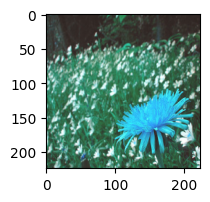

In [30]:
plt.figure(figsize=(15,2))
plt.imshow(x_train[0])

In [31]:
# to train existing model we have to use one of it's version - without layer
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable = False)

In [32]:
num_of_flowers = 5

# create model with only last layer
model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [34]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy',],
    
)

In [35]:
model.fit(train_gen, epochs = 5)

Epoch 1/5
86/86 [==============================] - 53s 511ms/step - loss: 0.7785 - accuracy: 0.7097
Epoch 2/5
86/86 [==============================] - 42s 487ms/step - loss: 0.4047 - accuracy: 0.8557
Epoch 3/5
86/86 [==============================] - 42s 493ms/step - loss: 0.3209 - accuracy: 0.8906
Epoch 4/5
86/86 [==============================] - 42s 486ms/step - loss: 0.2679 - accuracy: 0.9102
Epoch 5/5
86/86 [==============================] - 42s 491ms/step - loss: 0.2287 - accuracy: 0.9317


In [36]:
model.evaluate(x_test, y_test)

29/29 [==============================] - 20s 545ms/step - loss: 0.3775 - accuracy: 0.8529


[0.3774679899215698, 0.8529411554336548]

In [37]:
# Its nice accuracy with little of computation
# so time and money is saved